"""
Risk Formula Benchmark
Comparing Multiplicative vs Additive Greenwashing Risk Models
"""


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    average_precision_score
)

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from greenwashing_analyzer import GreenwashingAnalyzer
import warnings
warnings.filterwarnings("ignore")


In [12]:
def load_and_prepare_data(
    csv_path,
    label_column="greenwashing",
    text_column="combined_text",
    filter_labels=True
):
    """
    Load and optionally clean dataset.
    """

    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)

    if filter_labels:
        df_clean = df[df[label_column].isin(
            ["greenwashing", "not_greenwashing"]
        )].copy()

        print(f"Total samples: {len(df)}")
        print(f"Clean samples (excluding errors/uncertain): {len(df_clean)}")
    else:
        df_clean = df.copy()
        print(f"Total samples: {len(df)}")

    print("\nLabel distribution:")
    print(df_clean[label_column].value_counts())

    return df_clean


In [13]:
def run_risk_formula_predictions(
    df,
    analyzer,
    text_column="combined_text",
    threshold=0.4
):
    print("\n" + "="*70)
    print("Running risk formula predictions...")
    print("="*70)

    mult_scores, add_scores = [], []
    mult_labels, add_labels = [], []

    total = len(df)
    for idx, row in df.iterrows():
        text = row[text_column]

        mult = analyzer.analyze(text)
        add = analyzer.analyze_additive(text)

        mult_scores.append(mult["risk_score"])
        add_scores.append(add["risk_score"])

        mult_labels.append(
            "greenwashing" if mult["risk_score"] >= threshold else "not_greenwashing"
        )
        add_labels.append(
            "greenwashing" if add["risk_score"] >= threshold else "not_greenwashing"
        )

        if (idx + 1) % 20 == 0:
            print(f"Processed {idx + 1}/{total} samples...")

    df["risk_mult"] = mult_scores
    df["risk_add"] = add_scores
    df["pred_mult"] = mult_labels
    df["pred_add"] = add_labels

    print("✓ Predictions complete!")
    return df


In [14]:
def calculate_formula_metrics(y_true, y_pred, method_name):
    y_true_bin = (y_true == "greenwashing").astype(int)
    y_pred_bin = (y_pred == "greenwashing").astype(int)

    accuracy = accuracy_score(y_true_bin, y_pred_bin)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    cm = confusion_matrix(y_true_bin, y_pred_bin)

    print(f"\n{'='*70}")
    print(f"{method_name.upper()} - METRICS")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "y_true_binary": y_true_bin
    }


In [15]:
def print_formula_comparison(metrics_mult, metrics_add):
    print(f"\n{'='*70}")
    print("RISK FORMULA COMPARISON SUMMARY")
    print(f"{'='*70}")

    comparison_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
        "Multiplicative": [
            metrics_mult["accuracy"],
            metrics_mult["precision"],
            metrics_mult["recall"],
            metrics_mult["f1"]
        ],
        "Additive": [
            metrics_add["accuracy"],
            metrics_add["precision"],
            metrics_add["recall"],
            metrics_add["f1"]
        ]
    })

    comparison_df["Difference"] = (
        comparison_df["Multiplicative"] - comparison_df["Additive"]
    )

    comparison_df["Better Method"] = comparison_df["Difference"].apply(
        lambda x: "Multiplicative" if x > 0.01 else
                  "Additive" if x < -0.01 else
                  "Similar"
    )

    print(comparison_df.to_string(index=False))
    return comparison_df


In [16]:
def plot_risk_formula_evaluation(
    df,
    metrics_mult,
    metrics_add,
    save_path="risk_formula_evaluation.png",
    dataset_name="Dataset",
    label_column="greenwashing"
):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(
        f"Greenwashing Detection – Risk Formula Comparison\n{dataset_name}",
        fontsize=16,
        fontweight="bold"
    )

    # -------------------------------------------------
    # Row 1: Confusion Matrices
    # -------------------------------------------------
    for idx, (metrics, title) in enumerate([
        (metrics_mult, "Multiplicative Risk"),
        (metrics_add, "Additive Risk")
    ]):
        cm = metrics["confusion_matrix"]
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=axes[0, idx],
            xticklabels=["Not GW", "GW"],
            yticklabels=["Not GW", "GW"]
        )
        axes[0, idx].set_title(f"{title}\nConfusion Matrix")
        axes[0, idx].set_xlabel("Predicted")
        axes[0, idx].set_ylabel("Actual")

    # -------------------------------------------------
    # Metrics Bar Chart
    # -------------------------------------------------
    metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score"]
    x = np.arange(len(metrics_names))
    width = 0.35

    mult_scores = [
        metrics_mult["accuracy"],
        metrics_mult["precision"],
        metrics_mult["recall"],
        metrics_mult["f1"]
    ]
    add_scores = [
        metrics_add["accuracy"],
        metrics_add["precision"],
        metrics_add["recall"],
        metrics_add["f1"]
    ]

    axes[0, 2].bar(x - width/2, mult_scores, width, label="Multiplicative", alpha=0.8)
    axes[0, 2].bar(x + width/2, add_scores, width, label="Additive", alpha=0.8)
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(metrics_names, rotation=45)
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].set_title("Metrics Comparison")
    axes[0, 2].legend()
    axes[0, 2].grid(axis="y", alpha=0.3)

    # -------------------------------------------------
    # Row 2: ROC Curves
    # -------------------------------------------------
    fpr_m, tpr_m, _ = roc_curve(
        metrics_mult["y_true_binary"], df["risk_mult"]
    )
    fpr_a, tpr_a, _ = roc_curve(
        metrics_add["y_true_binary"], df["risk_add"]
    )

    auc_m = auc(fpr_m, tpr_m)
    auc_a = auc(fpr_a, tpr_a)

    axes[1, 0].plot(fpr_m, tpr_m, label=f"Multiplicative (AUC={auc_m:.3f})", linewidth=2)
    axes[1, 0].plot(fpr_a, tpr_a, label=f"Additive (AUC={auc_a:.3f})", linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], "k--", label="Random")
    axes[1, 0].set_xlabel("False Positive Rate")
    axes[1, 0].set_ylabel("True Positive Rate")
    axes[1, 0].set_title("ROC Curves")
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # -------------------------------------------------
    # Precision–Recall Curves
    # -------------------------------------------------
    prec_m, rec_m, _ = precision_recall_curve(
        metrics_mult["y_true_binary"], df["risk_mult"]
    )
    prec_a, rec_a, _ = precision_recall_curve(
        metrics_add["y_true_binary"], df["risk_add"]
    )

    ap_m = average_precision_score(
        metrics_mult["y_true_binary"], df["risk_mult"]
    )
    ap_a = average_precision_score(
        metrics_add["y_true_binary"], df["risk_add"]
    )

    axes[1, 1].plot(rec_m, prec_m, label=f"Multiplicative (AP={ap_m:.3f})", linewidth=2)
    axes[1, 1].plot(rec_a, prec_a, label=f"Additive (AP={ap_a:.3f})", linewidth=2)
    axes[1, 1].set_xlabel("Recall")
    axes[1, 1].set_ylabel("Precision")
    axes[1, 1].set_title("Precision–Recall Curves")
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    # -------------------------------------------------
    # Score Distributions
    # -------------------------------------------------
    axes[1, 2].hist(
        df[df[label_column] == "greenwashing"]["risk_mult"],
        bins=20, alpha=0.5, label="Multiplicative (GW)"
    )
    axes[1, 2].hist(
        df[df[label_column] == "greenwashing"]["risk_add"],
        bins=20, alpha=0.5, label="Additive (GW)"
    )
    axes[1, 2].axvline(0.4, linestyle="--", label="Threshold (0.4)")
    axes[1, 2].set_xlabel("Risk Score")
    axes[1, 2].set_ylabel("Frequency")
    axes[1, 2].set_title("Risk Score Distribution (GW)")
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"\n✓ Visualization saved as '{save_path}'")

    return auc_m, auc_a, ap_m, ap_a


In [17]:
def run_full_risk_formula_evaluation(
    csv_path,
    analyzer,
    dataset_name,
    label_column="greenwashing",
    text_column="combined_text"
):
    print(f"\n{'#'*70}")
    print(f"# EVALUATING: {dataset_name}")
    print(f"{'#'*70}\n")

    df = load_and_prepare_data(csv_path, label_column, text_column)
    df = run_risk_formula_predictions(df, analyzer, text_column)

    metrics_mult = calculate_formula_metrics(
        df[label_column], df["pred_mult"], "Multiplicative Risk"
    )
    metrics_add = calculate_formula_metrics(
        df[label_column], df["pred_add"], "Additive Risk"
    )

    comparison_df = print_formula_comparison(metrics_mult, metrics_add)
    auc_m, auc_a, ap_m, ap_a = plot_risk_formula_evaluation(
        df,
        metrics_mult,
        metrics_add,
        save_path=f"{dataset_name.replace(' ', '_').lower()}_risk_formula.png",
        dataset_name=dataset_name,
        label_column=label_column
    )

    return {
        "metrics_mult": metrics_mult,
        "metrics_add": metrics_add,
        "comparison_df": comparison_df,
        "roc_auc": {"mult": auc_m, "add": auc_a},
        "avg_precision": {"mult": ap_m, "add": ap_a}
    }


Device set to use mps:0



######################################################################
# EVALUATING: Zero-Shot Dataset
######################################################################

Loading data from ../data/benchmark/greenwashing_zero_shot.csv...
Total samples: 100
Clean samples (excluding errors/uncertain): 100

Label distribution:
greenwashing
greenwashing        64
not_greenwashing    36
Name: count, dtype: int64

Running risk formula predictions...
Processed 20/100 samples...
Processed 40/100 samples...
Processed 60/100 samples...
Processed 80/100 samples...
Processed 100/100 samples...
✓ Predictions complete!

MULTIPLICATIVE RISK - METRICS
Accuracy:  0.6200
Precision: 0.6548
Recall:    0.8594
F1-Score:  0.7432

Confusion Matrix:
[[ 7 29]
 [ 9 55]]

ADDITIVE RISK - METRICS
Accuracy:  0.6400
Precision: 0.6458
Recall:    0.9688
F1-Score:  0.7750

Confusion Matrix:
[[ 2 34]
 [ 2 62]]

RISK FORMULA COMPARISON SUMMARY
   Metric  Multiplicative  Additive  Difference Better Method
 Accuracy   

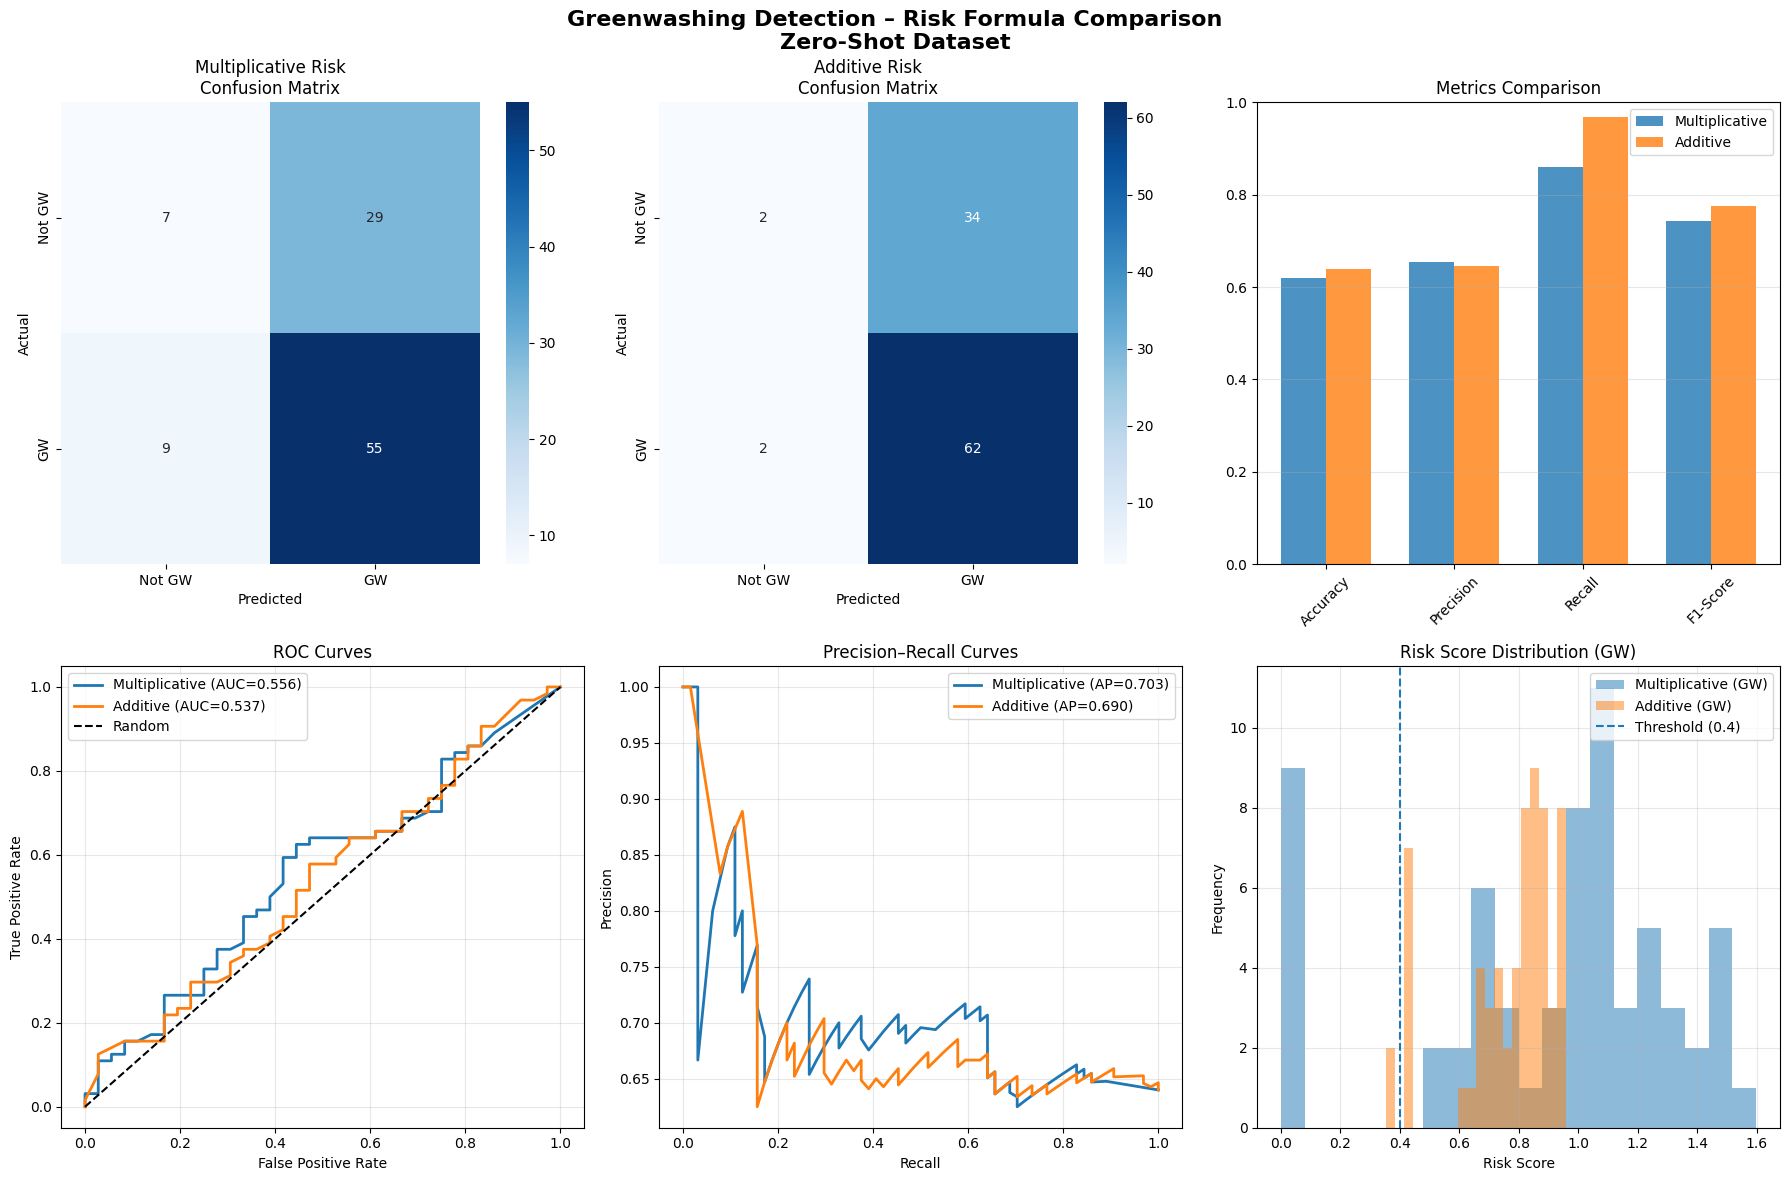


✓ Visualization saved as 'zero-shot_dataset_risk_formula.png'

######################################################################
# EVALUATING: One-Shot Dataset
######################################################################

Loading data from ../data/benchmark/greenwashing_one_shot.csv...
Total samples: 100
Clean samples (excluding errors/uncertain): 100

Label distribution:
greenwashing
greenwashing        60
not_greenwashing    40
Name: count, dtype: int64

Running risk formula predictions...
Processed 20/100 samples...
Processed 40/100 samples...
Processed 60/100 samples...
Processed 80/100 samples...
Processed 100/100 samples...
✓ Predictions complete!

MULTIPLICATIVE RISK - METRICS
Accuracy:  0.5800
Precision: 0.6071
Recall:    0.8500
F1-Score:  0.7083

Confusion Matrix:
[[ 7 33]
 [ 9 51]]

ADDITIVE RISK - METRICS
Accuracy:  0.6000
Precision: 0.6042
Recall:    0.9667
F1-Score:  0.7436

Confusion Matrix:
[[ 2 38]
 [ 2 58]]

RISK FORMULA COMPARISON SUMMARY
   Metric  Mu

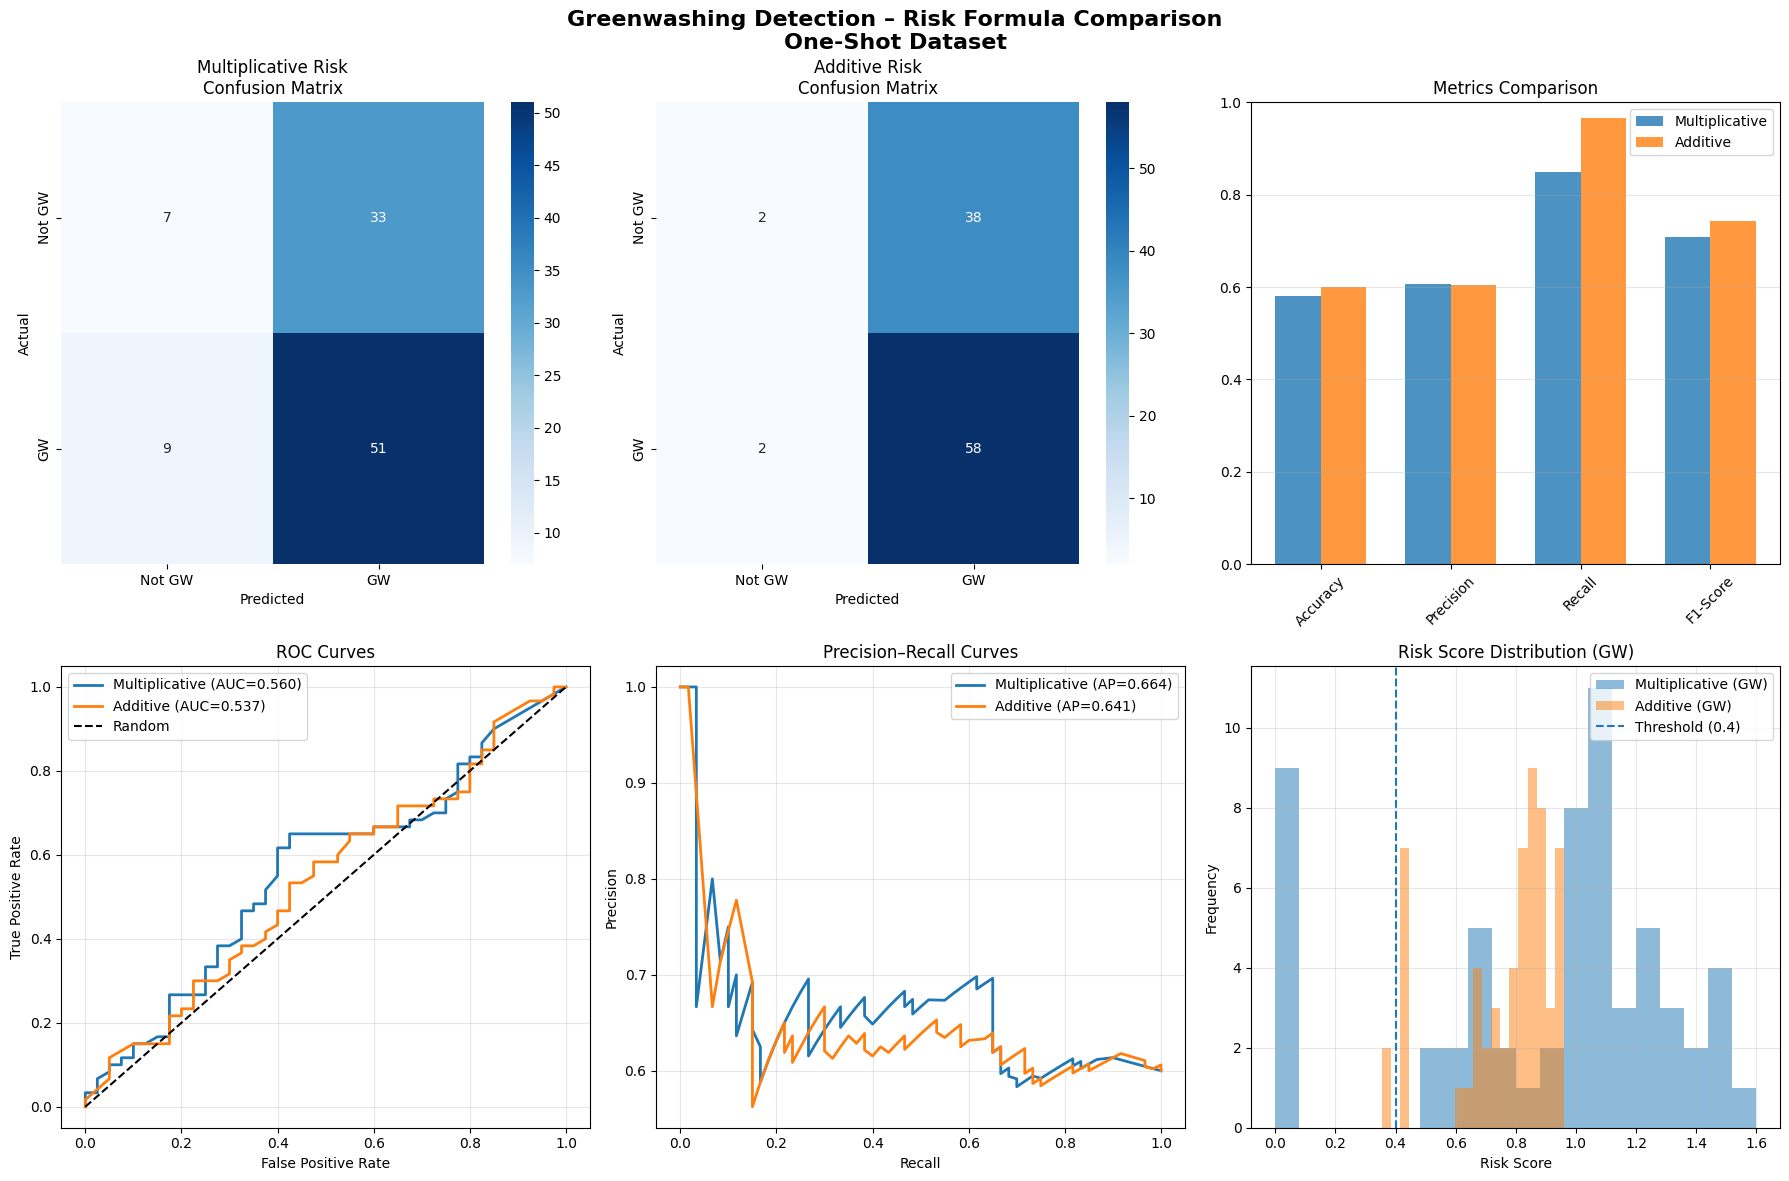


✓ Visualization saved as 'one-shot_dataset_risk_formula.png'

######################################################################
# EVALUATING: Chain-of-Thought Dataset
######################################################################

Loading data from ../data/benchmark/greenwashing_chain_of_thought.csv...
Total samples: 100
Clean samples (excluding errors/uncertain): 99

Label distribution:
greenwashing
greenwashing        69
not_greenwashing    30
Name: count, dtype: int64

Running risk formula predictions...
Processed 20/99 samples...
Processed 40/99 samples...
Processed 60/99 samples...
Processed 80/99 samples...
Processed 100/99 samples...
✓ Predictions complete!

MULTIPLICATIVE RISK - METRICS
Accuracy:  0.6566
Precision: 0.7108
Recall:    0.8551
F1-Score:  0.7763

Confusion Matrix:
[[ 6 24]
 [10 59]]

ADDITIVE RISK - METRICS
Accuracy:  0.6970
Precision: 0.7053
Recall:    0.9710
F1-Score:  0.8171

Confusion Matrix:
[[ 2 28]
 [ 2 67]]

RISK FORMULA COMPARISON SUMMARY
   M

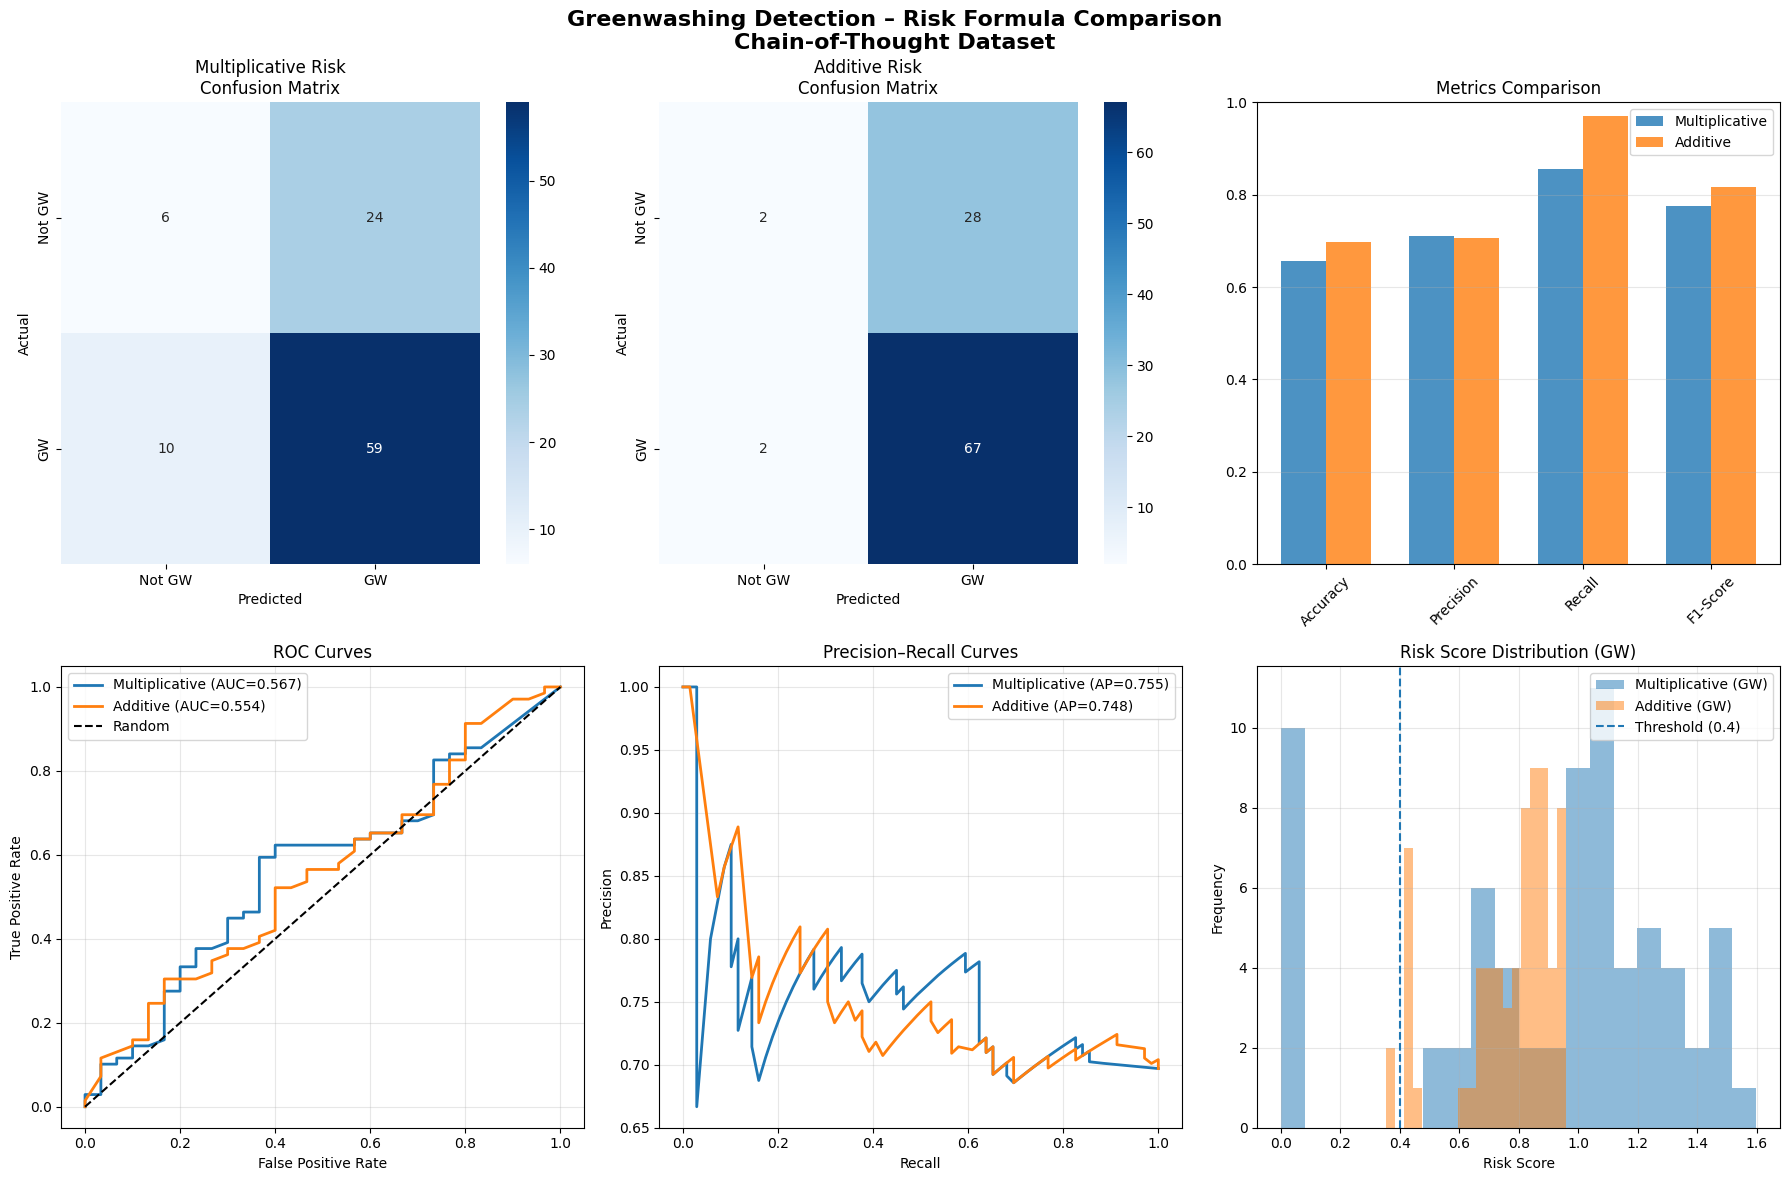


✓ Visualization saved as 'chain-of-thought_dataset_risk_formula.png'


In [18]:
analyzer = GreenwashingAnalyzer("../models/specificity")

datasets_to_evaluate = [
    {
        "csv_path": "../data/benchmark/greenwashing_zero_shot.csv",
        "dataset_name": "Zero-Shot Dataset"
    },
    {
        "csv_path": "../data/benchmark/greenwashing_one_shot.csv",
        "dataset_name": "One-Shot Dataset"
    },
    {
        "csv_path": "../data/benchmark/greenwashing_chain_of_thought.csv",
        "dataset_name": "Chain-of-Thought Dataset"
    }
]

all_results = {}

for config in datasets_to_evaluate:
    results = run_full_risk_formula_evaluation(
        csv_path=config["csv_path"],
        analyzer=analyzer,
        dataset_name=config["dataset_name"]
    )
    all_results[config["dataset_name"]] = results
